# Transfer Learning for Flowers Image Classification
Use Google's pre-trained model (inception-resnet-v2) for training a new model for Flowers classification problem. This is done by the use of TensorFlow-slim.

## Converting to TFRecords
First, convert images that are already PROPERLY arranged in sub-directories according to their classes into a readable format for TensorFlow. This is preferred way of accessing images because you don't have to read in raw images in real-time as you train; it's much faster than reading images from disk.

In [1]:
import tensorflow as tf
from tensorflow.contrib.framework.python.ops.variables import get_or_create_global_step
from tensorflow.python.platform import tf_logging as logging

import os
import time
slim = tf.contrib.slim

In [2]:
# the dataset directory will be path/to/flowers and not path/to/flowers/flowers_photos.
# flowers\
#     flower_photos\
#         tulips\
#             ....jpg
#         sunflowers\
#             ....jpg
#         ...

# We don't want to reinvent the wheels as slim has already most of the code available for writing TFRecord files.

import random
import tensorflow as tf
from util.dataset_utils import _dataset_exists, _get_filenames_and_classes, write_label_file, _convert_dataset

path_to_data = 'data/flowers'
tfrecord_filename = 'flowers'
validation_size = 0.3
random_seed = 0

In [ ]:
photo_filenames, class_names = _get_filenames_and_classes(path_to_data)
class_names_to_ids = dict(zip(class_names, range(len(class_names))))


num_validation = int(len(photo_filenames) * validation_size)

random.seed(random_seed)
random.shuffle(photo_filenames)
training_filenames = photo_filenames[num_validation:]
validation_filenames = photo_filenames[:num_validation]

# Convert the training and validation sets
_convert_dataset('train', training_filenames, class_names_to_ids,
                 dataset_dir = path_to_data,
                 tfrecord_filename = tfrecord_filename,
                 _NUM_SHARDS = 2)
_convert_dataset('validation', validation_filenames, class_names_to_ids,
                 dataset_dir = path_to_data,
                 tfrecord_filename = tfrecord_filename,
                 _NUM_SHARDS = 2)

# Write the labels file:
labels_to_class_names = dict(zip(range(len(class_names)), class_names))
write_label_file(labels_to_class_names, path_to_data)

## Training from inception_resnet_v2


In [3]:
import model.inception_preprocessing
from model.inception_resnet_v2 import inception_resnet_v2, inception_resnet_v2_arg_scope

#================ DATASET INFORMATION ======================
#State dataset directory where the tfrecord files are located
dataset_dir = path_to_data

#State where your log file is at. If it doesn't exist, create it.
log_dir = './log'

#State where your checkpoint file is
checkpoint_file = './model/inception_resnet_v2_2016_08_30.ckpt'

#State the image size you're resizing your images to. We will use the default inception size of 299.
image_size = 299

#State the number of classes to predict:
num_classes = 5

#State the labels file and read it
labels_file = path_to_data + '/labels.txt'
labels = open(labels_file, 'r')

#Create a dictionary to refer each label to their string name
labels_to_name = {}
for line in labels:
    label, string_name = line.split(':')
    string_name = string_name[:-1] #Remove newline
    labels_to_name[int(label)] = string_name

#Create the file pattern of your TFRecord files so that it could be recognized later on
file_pattern = tfrecord_filename + '_%s_*.tfrecord'

#Create a dictionary that will help people understand your dataset better. This is required by the Dataset class later.
items_to_descriptions = {
    'image': 'A 3-channel RGB coloured flower image that is either tulips, sunflowers, roses, dandelion, or daisy.',
    'label': 'A label that is as such -- 0:daisy, 1:dandelion, 2:roses, 3:sunflowers, 4:tulips'
}


#================= TRAINING INFORMATION ==================
#State the number of epochs to train
num_epochs = 1

#State your batch size
batch_size = 8

#Learning rate information and configuration (Up to you to experiment)
initial_learning_rate = 0.0002
learning_rate_decay_factor = 0.7
num_epochs_before_decay = 2

In [5]:
from util.train_utils import load_batch, get_split

if not os.path.exists(log_dir):
    os.mkdir(log_dir)
    
# Training Process
with tf.Graph().as_default() as graph:
    tf.logging.set_verbosity(tf.logging.INFO) #Set the verbosity to INFO level
    
    # Create the dataset and load one batch
    dataset = get_split('train', dataset_dir, file_pattern, 'flowers', labels_to_name, items_to_descriptions)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size, batch_size=batch_size)
    
    # Know the number steps to take before decaying the learning ratre and batches per epoch
    num_batches_per_epoch = int(dataset.num_samples / batch_size)
    num_steps_per_epoch = num_batches_per_epoch # Because one step is one batch processed
    decay_steps = int(num_epochs_before_decay * num_steps_per_epoch)
    
    # Create the model inference
    with slim.arg_scope(inception_resnet_v2_arg_scope()):
            logits, end_points = inception_resnet_v2(images, num_classes = dataset.num_classes, is_training = True)

    #Define the scopes that you want to exclude for restoration
    exclude = ['InceptionResnetV2/Logits', 'InceptionResnetV2/AuxLogits']
    variables_to_restore = slim.get_variables_to_restore(exclude = exclude)

    #Perform one-hot-encoding of the labels (Try one-hot-encoding within the load_batch function!)
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)

    #Performs the equivalent to tf.nn.sparse_softmax_cross_entropy_with_logits but enhanced with checks
    loss = tf.losses.softmax_cross_entropy(onehot_labels = one_hot_labels, logits = logits)
    total_loss = tf.losses.get_total_loss()    #obtain the regularization losses as well

    #Create the global step for monitoring the learning_rate and training.
    global_step = get_or_create_global_step()

    #Define your exponentially decaying learning rate
    lr = tf.train.exponential_decay(
        learning_rate = initial_learning_rate,
        global_step = global_step,
        decay_steps = decay_steps,
        decay_rate = learning_rate_decay_factor,
        staircase = True)

    #Now we can define the optimizer that takes on the learning rate
    optimizer = tf.train.AdamOptimizer(learning_rate = lr)

    #Create the train_op.
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    #State the metrics that you want to predict. We get a predictions that is not one_hot_encoded.
    predictions = tf.argmax(end_points['Predictions'], 1)
    probabilities = end_points['Predictions']
    accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, labels)
    metrics_op = tf.group(accuracy_update, probabilities)


    #Now finally create all the summaries you need to monitor and group them into one summary op.
    tf.summary.scalar('losses/Total_Loss', total_loss)
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('learning_rate', lr)
    my_summary_op = tf.summary.merge_all()

    #Now we need to create a training step function that runs both the train_op, metrics_op and updates the global_step concurrently.
    def train_step(sess, train_op, global_step):
        '''
        Simply runs a session for the three arguments provided and gives a logging on the time elapsed for each global step
        '''
        #Check the time for each sess run
        start_time = time.time()
        total_loss, global_step_count, _ = sess.run([train_op, global_step, metrics_op])
        time_elapsed = time.time() - start_time

        #Run the logging to print some results
        logging.info('global step %s: loss: %.4f (%.2f sec/step)', global_step_count, total_loss, time_elapsed)

        return total_loss, global_step_count

    #Now we create a saver function that actually restores the variables from a checkpoint file in a sess
    saver = tf.train.Saver(variables_to_restore)
    def restore_fn(sess):
        return saver.restore(sess, checkpoint_file)

    #Define your supervisor for running a managed session. Do not run the summary_op automatically or else it will consume too much memory
    sv = tf.train.Supervisor(logdir = log_dir, summary_op = None, init_fn = restore_fn)


    #Run the managed session
    with sv.managed_session() as sess:
        for step in range(num_steps_per_epoch * num_epochs):
            #At the start of every epoch, show the vital information:
            if step % num_batches_per_epoch == 0:
                logging.info('Epoch %s/%s', step/num_batches_per_epoch + 1, num_epochs)
                learning_rate_value, accuracy_value = sess.run([lr, accuracy])
                logging.info('Current Learning Rate: %s', learning_rate_value)
                logging.info('Current Streaming Accuracy: %s', accuracy_value)

                # optionally, print your logits and predictions for a sanity check that things are going fine.
                logits_value, probabilities_value, predictions_value, labels_value = sess.run([logits, probabilities, predictions, labels])
                print ('logits: \n', logits_value)
                print ('Probabilities: \n', probabilities_value)
                print ('predictions: \n', predictions_value)
                print ('Labels:\n:', labels_value)

            #Log the summaries every 10 step.
            if step % 10 == 0:
                loss, _ = train_step(sess, train_op, sv.global_step)
                summaries = sess.run(my_summary_op)
                sv.summary_computed(sess, summaries)

            #If not, simply run the training step
            else:
                loss, _ = train_step(sess, train_op, sv.global_step)

        #We log the final training loss and accuracy
        logging.info('Final Loss: %s', loss)
        logging.info('Final Accuracy: %s', sess.run(accuracy))

        #Once all the training has been done, save the log files and checkpoint model
        logging.info('Finished training! Saving model to disk now.')
        # saver.save(sess, "./flowers_model.ckpt")
        sv.saver.save(sess, sv.save_path, global_step = sv.global_step)

INFO:tensorflow:Restoring parameters from ./log/model.ckpt-0
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path ./log/model.ckpt
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Epoch 1.0/1
INFO:tensorflow:Current Learning Rate: 0.0002
INFO:tensorflow:Current Streaming Accuracy: 0.0
logits: 
 [[ 0.35362494  0.39457145 -0.06425844  0.28840467  0.42084134]
 [ 0.47441155  0.18193038  0.04167911 -0.12484793  0.1106564 ]
 [ 0.15664741  0.21237262 -0.26989868 -0.44197196  0.51300573]
 [ 0.18699436  0.22540781  0.13318236 -0.03884184  0.50295579]
 [-0.72867358  0.13453895 -0.07139477 -0.14513938 -0.01567598]
 [-0.17348561  0.77985072  0.56869304  0.06839168  0.29678306]
 [-0.00318444 -0.21022119  0.72773361 -0.26960832  0.75824964]
 [-0.01077469  0.51389623  0.60426116  0.01955307  0.090708  ]]
Probabilities: 
 [[ 0.21246654  0.22134686  0.13989624  0.19905163  0.22723867]
 [ 0.27476883  0.20509002  0.17825189  0.150

INFO:tensorflow:global step 102: loss: 1.3170 (17.68 sec/step)
INFO:tensorflow:global step 103: loss: 1.4175 (17.56 sec/step)
INFO:tensorflow:global step 104: loss: 2.5244 (19.09 sec/step)
INFO:tensorflow:global step 105: loss: 0.8826 (17.88 sec/step)
INFO:tensorflow:global step 106: loss: 1.0880 (17.85 sec/step)
INFO:tensorflow:global step 107: loss: 1.2366 (17.90 sec/step)
INFO:tensorflow:global step 108: loss: 0.8446 (17.84 sec/step)
INFO:tensorflow:global step 109: loss: 1.8941 (17.84 sec/step)
INFO:tensorflow:global step 110: loss: 1.5240 (17.94 sec/step)
INFO:tensorflow:global step 111: loss: 1.4191 (18.02 sec/step)
INFO:tensorflow:global step 112: loss: 0.9266 (17.93 sec/step)
INFO:tensorflow:global step 113: loss: 0.7254 (17.95 sec/step)
INFO:tensorflow:global step 114: loss: 1.2259 (17.85 sec/step)
INFO:tensorflow:global step 115: loss: 1.0093 (17.88 sec/step)
INFO:tensorflow:global step 116: loss: 1.1197 (18.14 sec/step)
INFO:tensorflow:global step 117: loss: 0.6981 (17.87 se

INFO:tensorflow:global step 229: loss: 1.3677 (18.01 sec/step)
INFO:tensorflow:global step 230: loss: 0.8768 (17.99 sec/step)
INFO:tensorflow:global step 231: loss: 0.8301 (17.79 sec/step)
INFO:tensorflow:global step 232: loss: 1.1446 (17.82 sec/step)
INFO:tensorflow:global step 233: loss: 1.1877 (17.93 sec/step)
INFO:tensorflow:global step 234: loss: 0.9031 (17.83 sec/step)
INFO:tensorflow:global step 235: loss: 0.6973 (17.83 sec/step)
INFO:tensorflow:global step 236: loss: 0.7373 (17.79 sec/step)
INFO:tensorflow:global step 237: loss: 1.3481 (17.81 sec/step)
INFO:tensorflow:global step 238: loss: 0.8630 (17.77 sec/step)
INFO:tensorflow:global step 239: loss: 0.5684 (17.82 sec/step)
INFO:tensorflow:global step 240: loss: 0.8391 (17.83 sec/step)
INFO:tensorflow:global step 241: loss: 0.6269 (17.77 sec/step)
INFO:tensorflow:global step 242: loss: 0.9377 (17.92 sec/step)
INFO:tensorflow:global step 243: loss: 0.6775 (17.77 sec/step)
INFO:tensorflow:global step 244: loss: 0.9661 (17.99 se

## Evaluation

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#State your log directory where you can retrieve your model
log_dir = './log'

#Create a new evaluation log directory to visualize the validation process
log_eval = './log_eval_test'

#State the dataset directory where the validation set is found
dataset_dir = './data/flowers'

#State the batch_size to evaluate each time, which can be a lot more than the training batch
batch_size = 36

#State the number of epochs to evaluate
num_epochs = 1

#Get the latest checkpoint file
checkpoint_file = tf.train.latest_checkpoint(log_dir)

INFO:tensorflow:Restoring parameters from ./log/model.ckpt-321
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Epoch: 1.0/1
INFO:tensorflow:Current Streaming Accuracy: 0.0000
INFO:tensorflow:Global Step 1: Streaming Accuracy: 0.0000 (21.35 sec/step)
INFO:tensorflow:Global Step 2: Streaming Accuracy: 0.1944 (21.42 sec/step)
INFO:tensorflow:Global Step 3: Streaming Accuracy: 0.2083 (21.36 sec/step)
INFO:tensorflow:Global Step 4: Streaming Accuracy: 0.1944 (21.47 sec/step)
INFO:tensorflow:Global Step 5: Streaming Accuracy: 0.2083 (21.13 sec/step)
INFO:tensorflow:Global Step 6: Streaming Accuracy: 0.2056 (22.78 sec/step)
INFO:tensorflow:Global Step 7: Streaming Accuracy: 0.2130 (21.28 sec/step)
INFO:tensorflow:Global Step 8: Streaming Accuracy: 0.2024 (21.11 sec/step)
INFO:tensorflow:Global Step 9: Streaming Accuracy: 0.1910 (21.06 sec/step)
INFO:tensorflow:Global Step 10: Streaming Accuracy: 0.1852 (21.46 sec/step)
INFO:tensorflow:Global

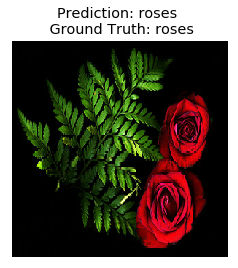

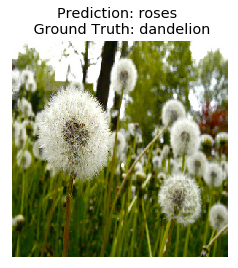

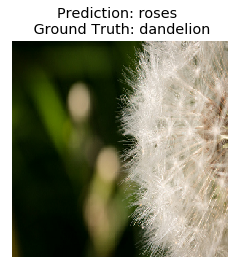

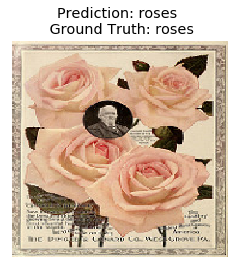

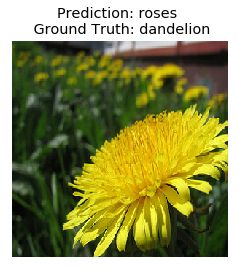

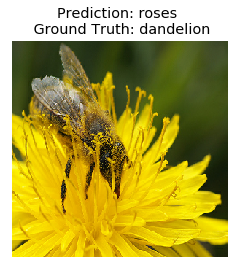

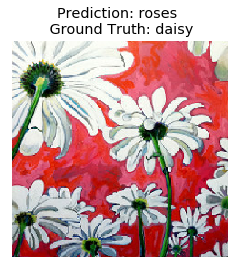

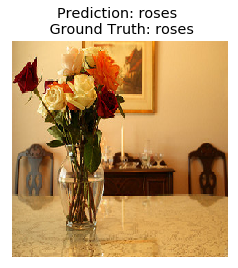

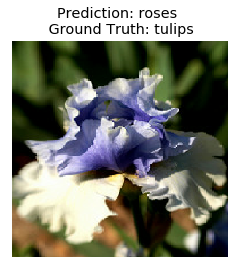

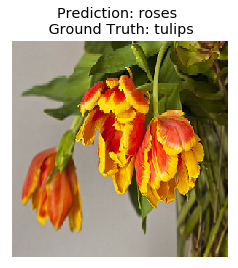

INFO:tensorflow:Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.


In [13]:
#Create log_dir for evaluation information
if not os.path.exists(log_eval):
    os.mkdir(log_eval)

#Just construct the graph from scratch again
with tf.Graph().as_default() as graph:
    tf.logging.set_verbosity(tf.logging.INFO)
    #Get the dataset first and load one batch of validation images and labels tensors. Set is_training as False so as to use the evaluation preprocessing
    dataset = get_split('validation', dataset_dir, file_pattern, 'flowers', labels_to_name, items_to_descriptions)
    images, raw_images, labels = load_batch(dataset, height=image_size, width=image_size, batch_size=batch_size, is_training = False)

    #Create some information about the training steps
    num_batches_per_epoch = dataset.num_samples / batch_size
    num_steps_per_epoch = num_batches_per_epoch

    #Now create the inference model but set is_training=False
    with slim.arg_scope(inception_resnet_v2_arg_scope()):
        logits, end_points = inception_resnet_v2(images, num_classes = dataset.num_classes, is_training = False)

    # #get all the variables to restore from the checkpoint file and create the saver function to restore
    variables_to_restore = slim.get_variables_to_restore()
    saver = tf.train.Saver(variables_to_restore)
    def restore_fn(sess):
        return saver.restore(sess, checkpoint_file)

    #Just define the metrics to track without the loss or whatsoever
    predictions = tf.argmax(end_points['Predictions'], 1)
    accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, labels)
    metrics_op = tf.group(accuracy_update)

    #Create the global step and an increment op for monitoring
    global_step = get_or_create_global_step()
    global_step_op = tf.assign(global_step, global_step + 1) #no apply_gradient method so manually increasing the global_step


    #Create a evaluation step function
    def eval_step(sess, metrics_op, global_step):
        '''
        Simply takes in a session, runs the metrics op and some logging information.
        '''
        start_time = time.time()
        _, global_step_count, accuracy_value = sess.run([metrics_op, global_step_op, accuracy])
        time_elapsed = time.time() - start_time

        #Log some information
        logging.info('Global Step %s: Streaming Accuracy: %.4f (%.2f sec/step)', global_step_count, accuracy_value, time_elapsed)

        return accuracy_value


    #Define some scalar quantities to monitor
    tf.summary.scalar('Validation_Accuracy', accuracy)
    my_summary_op = tf.summary.merge_all()

    #Get your supervisor
    sv = tf.train.Supervisor(logdir = log_eval, summary_op = None, saver = None, init_fn = restore_fn)

    #Now we are ready to run in one session
    with sv.managed_session() as sess:
        for step in range(int(num_steps_per_epoch * num_epochs)):
            sess.run(sv.global_step)
            #print vital information every start of the epoch as always
            if step % num_batches_per_epoch == 0:
                logging.info('Epoch: %s/%s', step / num_batches_per_epoch + 1, num_epochs)
                logging.info('Current Streaming Accuracy: %.4f', sess.run(accuracy))

            #Compute summaries every 10 steps and continue evaluating
            if step % 10 == 0:
                eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)
                summaries = sess.run(my_summary_op)
                sv.summary_computed(sess, summaries)


            #Otherwise just run as per normal
            else:
                eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)

        #At the end of all the evaluation, show the final accuracy
        logging.info('Final Streaming Accuracy: %.4f', sess.run(accuracy))

        #Now we want to visualize the last batch's images just to see what our model has predicted
        raw_images, labels, predictions = sess.run([raw_images, labels, predictions])
        for i in range(10):
            image, label, prediction = raw_images[i], labels[i], predictions[i]
            prediction_name, label_name = dataset.labels_to_name[prediction], dataset.labels_to_name[label]
            text = 'Prediction: %s \n Ground Truth: %s' %(prediction_name, label_name)
            img_plot = plt.imshow(image)

            #Set up the plot and hide axes
            plt.title(text)
            img_plot.axes.get_yaxis().set_ticks([])
            img_plot.axes.get_xaxis().set_ticks([])
            plt.show()

        logging.info('Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.')

In [ ]:
# How to integrate a TensorBoard view?